# Outlier Filter vielleicht besser am Ende

- threshold muss bei Kurven größer sein als bei geraden Strecken
- Problem wenn viele Ausreisser hintereinander (bei Gleisen weit abseits oder manchmal an Weichen (bei Nachbargleisen?))
- zu lange Strecken in Stücke zerteilen
- Start/Ende des Linestrings nicht ausfiltern 
- Bei langen kurvigen Linien funktioniert es erstaunlich gut, aber die gemessene Distanz ist nicht die Normale auf die Tangente. 
    - Idee: Wenn max distance > 50 o.ä., rekursiv halbieren 
    - Oder so lassen. Der Wert der "distanz" ist dann größer, aber wenn das keine Probleme verursacht...

In [1]:
import sys
import os
import numpy as np
from osgeo import ogr 
import matplotlib.pyplot as plt
from scipy import ndimage  



sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 
from algs.growingline import *

ogr.UseExceptions()

In [197]:
ds = None 

In [648]:

folder = "/media/riannek/minimax/gleis/"
file = os.path.join(folder, "needsfilter.gpkg")

ds = None 


ds = ogr.Open(file)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

['abseits', 'kurve', 'long lines', 'needsfilter', 'viele', 'viele1', 'weiche']


In [903]:
layer_name = "viele1"
layer = ds.GetLayerByName(layer_name)

features = list(layer)

In [904]:
allpoints = []
for f in features:
    geom = f.geometry()
    points = geom.GetPoints()
    allpoints.extend(points)
allpoints = np.array(allpoints)

In [905]:
layer.GetFeatureCount()

21

## Feature wählen

In [989]:
f = features[8]

geom = f.geometry()
points = geom.GetPoints()
print("length", geom.Length(), "points", len(points))
points = np.array(points)

x = points[:, 0]
y = points[:, 1]

length 405.8017148787058 points 432


In [1000]:
windowsize = 7
sigma_thresh = 2
min_threshold = 0.007

distances = distance_points_to_line(points, points[0], (points[-1] - points[0]) )
print("max dist", max(distances))

rolling_median = ndimage.median_filter(distances, size=windowsize)
distances_corrected = np.abs(distances - rolling_median)

# First and last point can have border effects, so we set them to zero
distances_corrected[0] = 0
distances_corrected[-1] = 0

thresh = sigma_thresh * np.std(distances_corrected)
thresh = max(min_threshold, thresh)
print("threshold", thresh, "STD", np.std(distances_corrected))
outliers = distances_corrected > thresh



print("outlier count", np.sum(outliers), "of", len(outliers))

max dist 13.290556592268274
threshold 0.01818321971610251 STD 0.009091609858051256
outlier count 2 of 432


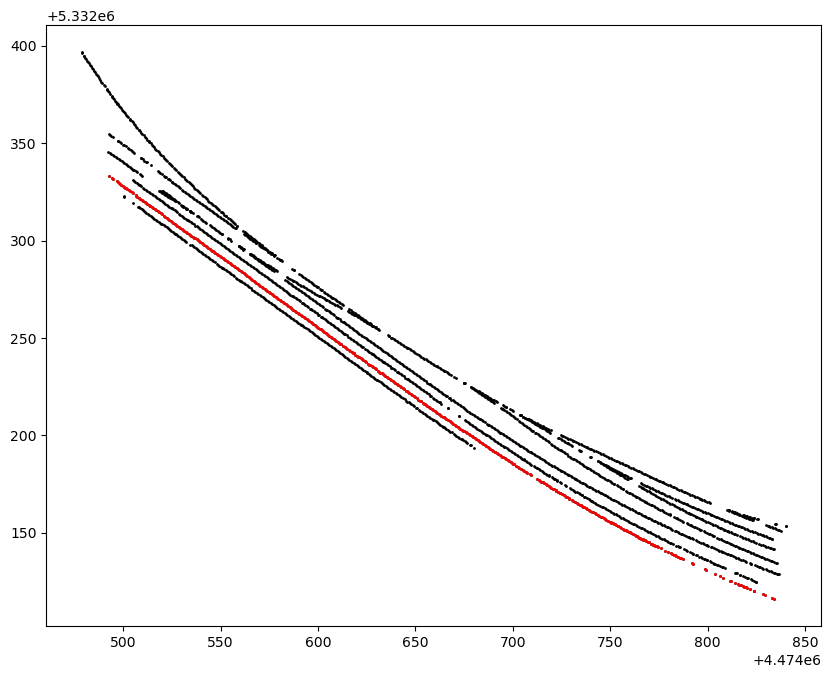

In [1001]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(allpoints[:, 0], allpoints[:, 1], "o", markersize=1, color="black")
ax.plot(x, y, "o", markersize=1, color="red")
ax.set_aspect("equal")

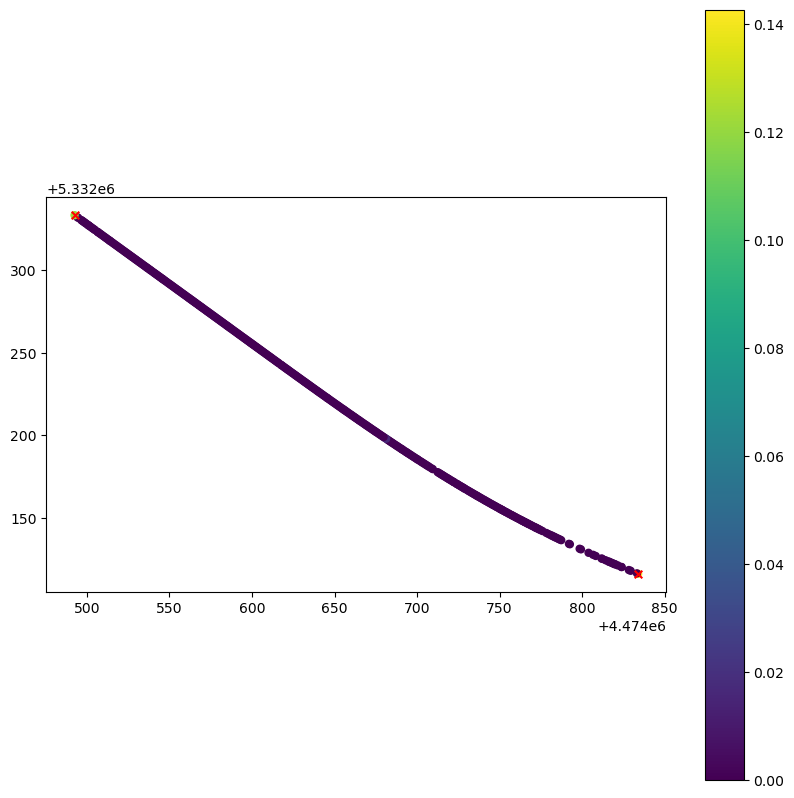

In [1002]:
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(x, y, c=distances_corrected, cmap="viridis", s=25, marker="o")
ax.scatter(x[outliers], y[outliers], color="red", s=30, marker="x")
plt.colorbar(sc, ax=ax)
ax.set_aspect("equal")

In [1003]:
multipoint = ogr.Geometry(ogr.wkbMultiPoint)
for p in points[outliers]:
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(p[0], p[1])
    multipoint.AddGeometry(point)


with open(os.path.join(folder, "outliers.geojson"), "w") as f:
    f.write(multipoint.ExportToJson())

In [1004]:
multipoint.ExportToJson()

'{ "type": "MultiPoint", "coordinates": [ [ 4474833.871528047136962, 5332116.127926172688603, 0.0 ], [ 4474492.521435241214931, 5332333.324734754860401, 0.0 ] ] }'

In [13]:
p = 0.99
w = 0.6
n = 2

np.log(1 - p) / np.log(1 - (1 - w) ** n)

np.float64(26.412851860251482)